## Import Packages

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=5e6177683f4557e1d6a57aaeee4010eeb1194831f68f51de7ba4b0776f345f5d
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
from pycocotools.coco import COCO
import requests
import wget
from google.colab import drive

import numpy as np
import matplotlib.pyplot as plt

from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave
import skimage.io as io

import glob
import shutil
import os

import tensorflow as tf
from keras.layers import Conv2D, UpSampling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Download Dataset

In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -o annotations_trainval2017.zip 

--2022-04-30 01:11:24--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.132.57
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.132.57|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  95.6MB/s    in 2.5s    

2022-04-30 01:11:27 (95.6 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [ ]:
# instantiate COCO specifying the annotations json path
coco = COCO("annotations/instances_train2017.json")
# Specify a list of category names of interest
catIds = coco.getCatIds(catNms=['train'])
# Get the corresponding image ids and images using loadImgs
imgIds = coco.getImgIds(catIds=catIds)
images = coco.loadImgs(imgIds)

loading annotations into memory...
Done (t=18.87s)
creating index...
index created!


In [ ]:
! mkdir ~/.Ground_Truth

coco.download('Ground_Truth', imgIds)

downloaded 0/3588 images (t=0.2s)
downloaded 1/3588 images (t=0.2s)
downloaded 2/3588 images (t=0.2s)
downloaded 3/3588 images (t=0.2s)
downloaded 4/3588 images (t=0.2s)
downloaded 5/3588 images (t=0.2s)
downloaded 6/3588 images (t=0.2s)
downloaded 7/3588 images (t=0.2s)
downloaded 8/3588 images (t=0.2s)
downloaded 9/3588 images (t=0.2s)
downloaded 10/3588 images (t=0.2s)
downloaded 11/3588 images (t=0.2s)
downloaded 12/3588 images (t=0.2s)
downloaded 13/3588 images (t=0.2s)
downloaded 14/3588 images (t=0.2s)
downloaded 15/3588 images (t=0.2s)
downloaded 16/3588 images (t=0.2s)
downloaded 17/3588 images (t=0.2s)
downloaded 18/3588 images (t=0.2s)
downloaded 19/3588 images (t=0.2s)
downloaded 20/3588 images (t=0.2s)
downloaded 21/3588 images (t=0.2s)
downloaded 22/3588 images (t=0.2s)
downloaded 23/3588 images (t=0.2s)
downloaded 24/3588 images (t=0.2s)
downloaded 25/3588 images (t=0.2s)
downloaded 26/3588 images (t=0.2s)
downloaded 27/3588 images (t=0.1s)
downloaded 28/3588 images (t=0

In [ ]:
! mkdir Train
! mkdir Test

mkdir: cannot create directory ‘Train’: File exists
mkdir: cannot create directory ‘Test’: File exists


In [ ]:
# move images to appropriate folders
source = '/content/Ground_Truth'
dest1 = '/content/Train'
dest2 = '/content/Test'

files = os.listdir(source)
index = 2511
i = 0

for f in files:
  if i <= index:
    shutil.move(os.path.join(source, f), dest1)
  else:
    shutil.move(os.path.join(source, f), dest2)
  i +=1

## Build Model

In [ ]:
# Get images
train = []
for filename in os.listdir('/content/Train/'):
    train.append(img_to_array(load_img('/content/Train/'+filename)))
train = np.array(train)

Xtrain = []

num=100
for i in range(0,num):
  tmp = train[i:i+num]
  tmp = tmp/255
  Xtrain.append(tmp)

#Xtrain = 1.0/255*train[:100,]
#Xtrain

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


In [ ]:
#Convert from RGB to LAB
X = []
y = []

for img in Xtrain:
  lab = rgb2lab(img)
  X.append(lab[:,:,0])
  y.append(lab[:,:,1:] / 128)

In [ ]:
X = X.reshape(100, 224, 224, 1)
y = y.reshape(100, 224, 224, 2)

ValueError: ignored

In [ ]:
# resize images
X = np.array(X)
y = np.array(y)

X = X.reshape(X.shape+(1,)) #dimensions to be the same for X and Y
print(X.shape)

(100, 1, 1)


In [ ]:
#Build model

# Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(224, 224, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))

# Decoder
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

# Compile model
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 256)       295168    
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 256)       590080    
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 512)       1180160   
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 512)       2

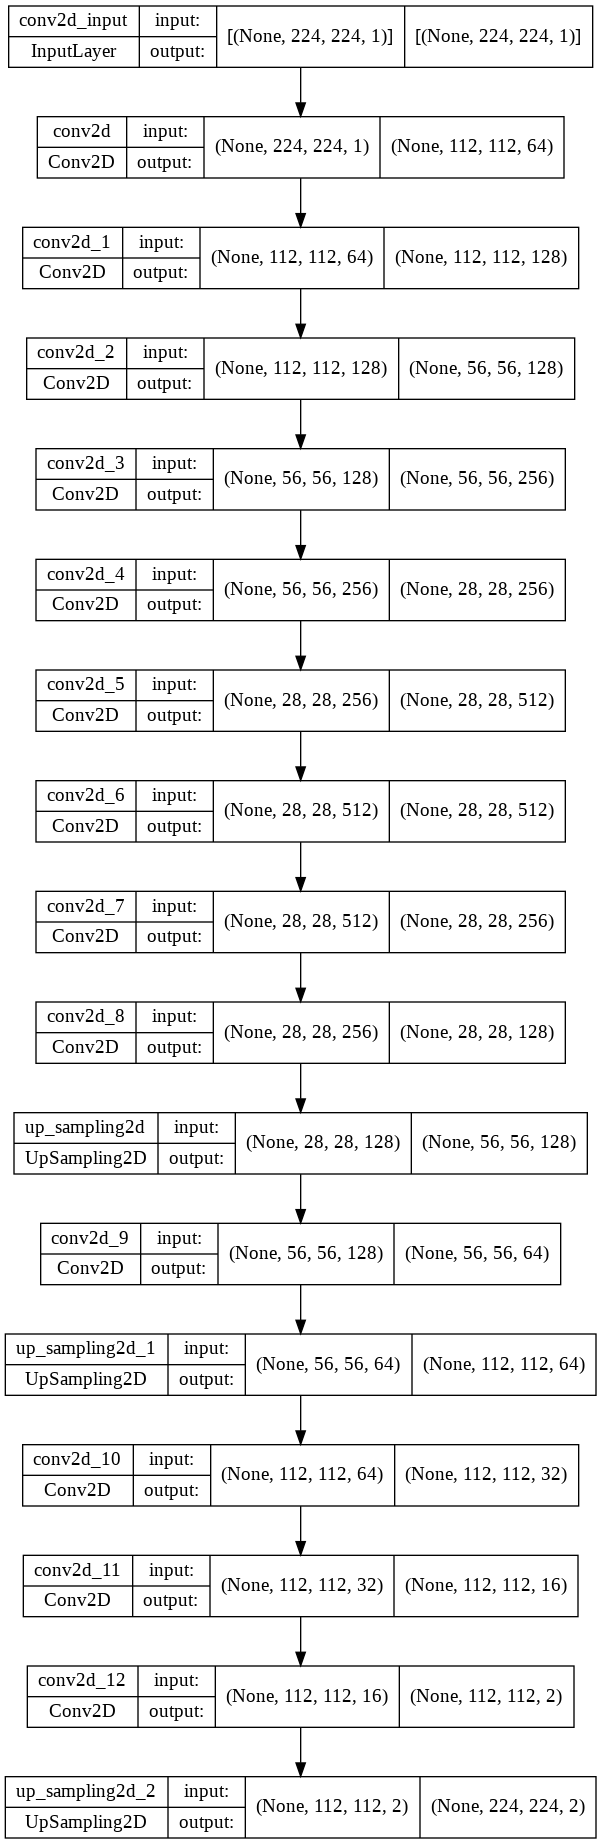

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train the model
trained_model = model.fit(x=X,y=y,validation_split=0.2, epochs=1000, batch_size=128)
print(model.evaluate(X,y, batch_size=64))

ValueError: ignored

In [ ]:
# Save model
model_json = trained_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

In [ ]:
# Load saved model
models = model.load_weights("model.h5")

In [ ]:
# Load test images
test = []
for filename in os.listdir('/content/Test/'):
    test.append(img_to_array(load_img('/content/Test/'+filename)))
test = np.array(test)

In [ ]:
#Convert to LAB
test_img = []

for img in test:
    lab = rgb2lab(img)
    test_img.append(lab[:,:,0])
test_img = np.array(test_img)

test_img = test_img.reshape(test_img.shape+(1,)) 

grayscale_img = np.zeros((224, 224, 3))
grayscale_img[:,:,0] = test_img[0][:,:,0]
gray_img = lab2rgb(grayscale_img)

output = model.predict(test_img)
output = output*128

result = np.zeros((224, 224, 3))
result[:,:,0] = test_img[0][:,:,0]
result[:,:,1:] = output[0]
colour_img = lab2rgb(result)

final = [gray_img, colour_img]